# Generalized Newton updates for Non-Conjugate Variational Bayes

In this post I show how to apply generalized Newton updates to achieve fast and easy to implement updates for non-conjugate mean-field variational inference. The rules integrate well with standard coordinate ascent / variational message passing, since they essentially locally approximate non-conjugate messages by conjugate ones. The method is restricted to situations where all expectations can be computed in closed form.

The main steps are

 1. Recognise that coordinate ascent updates are optimization problems
 1. In the locally conjugate case, this optimization can be solved in closed form
 1. Derivative matching a la [Beyond Newton's Method](https://tminka.github.io/papers/minka-newton.pdf) can be used to locally approximate the non-conjugate problem by a conjugate one, the solution of which is the udpate

## Example Problem

I use a Normal-Poisson model as a running example,

$$
\begin{align}
z &\sim \mathcal{N}(\mu_0, \sigma_0^2) \\
x &\sim \text{Poisson}\left(e^z\right)
\end{align}
$$

where $x$ is observed and the log-Poisson rate $z$ is to be inferred. We assume there are $n$ observations with sufficient statistics $k = \sum_{i=1}^n x_i$.

The ELBO for this model is

$$
\begin{align}
L[q] &= \mathbb{E}_{z\sim q}\left[\sum_{i=1}^n \log p(x_i \,|\, z) + \log p(z)\right] - \mathbb{E}_{z\sim q}\left[\log q(z)\right] \\
&= \mathbb{E}_{z \sim q}\left[ k z - n e^z - \frac{\left(z - \mu_0\right)^2}{2\sigma_0^2}\right] + \mathbb{H}[q] + \, \text{const}
\end{align}
$$

With a Gaussian variational distribution $q = \mathcal{N}(m, s^2)$ we can compute all expectations,

$$
L(m, s^2) = k m - n e^{m}e^{\frac{1}{2}s^2} - \frac{m^2 + s^2 - 2\mu_0 m}{2\sigma_0^2} + \frac{1}{2} \log s^2 + \,\text{const}
$$

When there are no observations ($n = k = 0$), the model is conjugate and the maximum be found exactly - unsurprisingly this is just $m = \mu_0, s^2 = \sigma_0^2$. The term $e^{m}e^{\frac{1}{2}s^2}$ spoils this, however. 

## Generalized Newton's Method

The idea behind the Newton method in minimization is to locally approximate a hard objective by a parabola by matching derivatives. The exact mimimum of the parabola is the next step in an iterative solution.

[Thomas Minka's generalized Newton's method](https://tminka.github.io/papers/minka-newton.pdf) consists in replacing the quadratic term by some other non-linear function that is tailored to the problem at hand.

This idea can be applied to variational inference by collecting all tractable terms and using these for approximating the intractable ones. Concretely, in the above we approximate

$$
-e^{m}e^{\frac{1}{2}s^2} \approx \text{const}\, + a_1 m - \frac{a_2}{2} m^2  - \frac{b_1}{2}s^2 + \frac{b_2}{2} \log s^2
$$

Matching the first two derivatives w.r.t. $m$ and $s^2$ leads to a triangular linear system with solution

$$
\begin{align}
a_1 &= (m - 1)\lambda \\
a_2 &= \lambda \\
b_1 &= \left(1 + \frac{s^2}{2}\right)\lambda \\
b_2 &= \frac{s^4}{2} \lambda
\end{align}
$$

where $\lambda = e^m e^{\frac{1}{2}s^2}$ is the expected Poisson rate.

## Approximate Update Rule

Plugging the approximation into the ELBO leads to a tractable optimization problem with solution

$$
\begin{align}
m_{\text{new}} &= \frac{\frac{\mu_0}{\sigma_0^2} + k +  n\lambda(m - 1)}{\frac{1}{\sigma_0^2} + n \lambda}\\
s^2_{\text{new}} &= \frac{1 + \frac{1}{2} n\lambda s^4}{\frac{1}{\sigma_0^2} + \left(1 + \frac{s^2}{2}\right) n \lambda}\\
\end{align}
$$


Some examples of the convergence are shown below for an empirical rate of $0.1$ and various $n$.


## Summary

The method outlined above seems to be reasonable for some non-conjugate problems. In the future, I may write updates on

 * other tractable examples, e.g. inverse-Gamma-Gamma
 * Comparison to other methods like the black-box VI

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [30]:
def normal_poisson(k, n, mu0, sigma0, max_iter=10):
    sig2 = sigma0**2
    # init with prior
    m = mu0
    s2 = sig2
    
    res = np.zeros((max_iter + 1, 2))
    res[0] = m, s2
    for i in range(max_iter):
        n_lambda = n * np.exp(m + .5 * s2)
        m = ((mu0 / sig2 + k + n_lambda * (m - 1)) / 
            (1. / sig2 + n_lambda))
        s2 = ((1 + .5 * n_lambda * s2**2) / 
             (1. / sig2 + (1 + .5 * s2) * n_lambda))
        res[i + 1] = m, s2
    return res

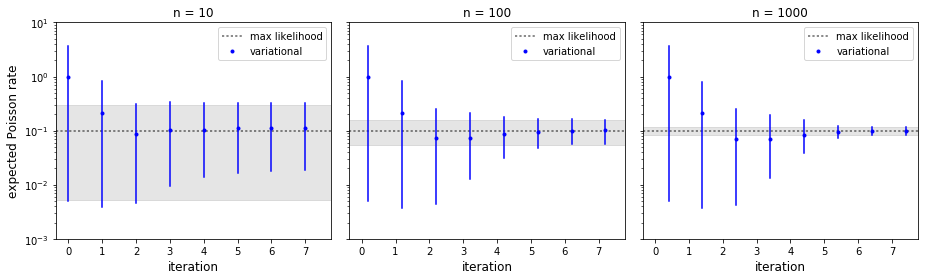

In [78]:
rate = .1
nvals = 10 * np.array([1, 10, 100])

fig, axes = plt.subplots(ncols=len(nvals), figsize=(13, 4), sharey=True, sharex=True)



kw = dict(fontsize='large')
offset = 0

axes[0].set_ylabel('expected Poisson rate', fontsize='large')
for ax, n in zip(axes, nvals):
    k = rate * n
    m, s2 = normal_poisson(k, n, -2., 2., max_iter=7).T
    lambda_ = np.exp(m + .5 * s2)
    lo, hi = stats.norm(m, np.sqrt(s2)).interval(.9)
    
    ax.set_title('n = %d' % n)
    ax.set_yscale('log')
    ax.set_xlabel('iteration', fontsize='large')
    ax.set_ylim((1e-3, 1e1))

    ax.axhline(rate, color='k', linestyle=':', alpha=.6, label='max likelihood')
    ax.axhspan(*stats.gamma(k, scale=1./n).interval(.9), color='k', alpha=.1)

    ax.plot(np.arange(lambda_.size) + offset, lambda_, 'b.', label='variational')
    for i, lohi in enumerate(zip(lo, hi)):
        ax.plot(2 * [i + offset], np.exp(lohi), 'b')

    None
    offset += .2
    
    ax.legend()

fig.tight_layout()
fig.savefig('../assets/img/normal-poisson-convergence.png')